In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

plt.rc('font', family='NanumBarunGothic') 

# 배경데이터

## 도로 데이터 (도로밀도)

### 도로 면적

In [ ]:
df_road = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/도로현황.xlsx', usecols = [0,3,6], names=['자치구','구분','도로면적'])
df_road.자치구 = df_road.자치구.fillna(0)

# 자치구의 총계만 추출
gu_li = []
for i in range(len(df_road)):
    if df_road.자치구.values[i] != 0:
        gu_li.append(i)
        gu_li.append(i+3)

df_road = df_road.iloc[gu_li,:].reset_index(drop=True)

# 자치구 이름 list에 추가
for i in range(len(df_road)):
    if i%2 == 1:
        df_road['자치구'][i] = df_road['자치구'][i-1]

# 면적으로 구분된 부분만 선택
df_road = df_road.query('구분 == "면적"')
df_road.drop(1,inplace=True)
df_road.set_index('자치구',inplace=True)

# km2기준 도로면적 계산
df_road['도로면적'] = round((df_road['도로면적'] / 1000000),2)

### 행정구역별 도로 밀도

In [ ]:
# 인구밀도 데이터에서 시군구별 면적데이터 추출
df_pop = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/인구밀도.csv',header=1,usecols=[1,2,4])
df_pop.drop(0, inplace=True)
df_pop.columns = ['자치구','동','면적']
df_pop = df_pop.query('동 == "소계"').reset_index(drop=True)
df_pop.drop('동',axis=1, inplace=True)
df_pop.set_index('자치구', inplace=True)

# 도로데이터에 삽입
df_road.insert(2,'면적',df_pop['면적'])
df_road.drop('구분',axis=1,inplace=True)

# 도로밀도 계산
df_road['road_km2'] = df_road['도로면적']/df_road['면적']

# 도로밀도만 남기기
df_road = df_road.iloc[:,[2]]
df_road

,road_km2
자치구,
종로구,0.112923
중구,0.188755
용산구,0.144033
성동구,0.179122
광진구,0.201641
동대문구,0.221519
중랑구,0.158919
성북구,0.172091
강북구,0.083898


## 교통사고 데이터

### 행정구역별 5년 평균 교통사고

In [ ]:
# 1차 데이터 정제
car_acc = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/교통사고.xlsx', usecols=[4,5,6,7,8,9])
car_acc = car_acc[:26]  ## 총 교통사고 건수만
car_acc.drop(0,inplace=True)
car_acc = car_acc.replace('-',0)
car_acc.rename(columns={'자치구별(2)':'자치구'},inplace=True)
car_acc.set_index('자치구',inplace=True)
car_acc = car_acc.astype(int)

# 5년간 교통사고 평균
car_acc['mean_acc'] = round(car_acc.mean(axis=1))

car_acc

,2017,2018,2019,2020,2021,mean_acc
자치구,,,,,,
종로구,1190,1134,1133,903,778,1028.0
중구,1252,1128,1184,955,854,1075.0
용산구,1337,1330,1187,890,1014,1152.0
성동구,1076,1143,1091,1119,1057,1097.0
광진구,1064,1108,973,869,922,987.0
동대문구,1718,1699,1565,1448,1390,1564.0
중랑구,1639,1565,1620,1447,1373,1529.0
성북구,1557,1427,1509,1275,1285,1411.0
강북구,1202,1216,1277,1087,1017,1160.0


### ** 도로 데이터에 삽입

In [ ]:
# 도로밀도 데이터에 교통사고 평균 데이터 삽입
df_road.insert(1,'mean_acc',car_acc['mean_acc'])

# 교통사고 평균 / 도로밀도
df_road['mean_acc/road_km2'] = round((df_road['mean_acc'] / df_road['road_km2']),4)

df_road

,road_km2,mean_acc,mean_acc/road_km2
자치구,,,
종로구,0.112923,1028.0,9103.5111
중구,0.188755,1075.0,5695.2128
용산구,0.144033,1152.0,7998.1714
성동구,0.179122,1097.0,6124.3113
광진구,0.201641,987.0,4894.8314
동대문구,0.221519,1564.0,7060.3429
중랑구,0.158919,1529.0,9621.2585
성북구,0.172091,1411.0,8199.1442
강북구,0.083898,1160.0,13826.2626


### 행정구역별 어린이 인구수 대비 어린이 교통사고

#### 어린이 인구수

In [ ]:
# 인구데이터에서 어린이 인구수만 추출
df_child=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/어린이인구.csv',usecols=[0,2])
df_child.drop(0,inplace=True)
df_child.columns = ['자치구', 'child_pop']
df_child['자치구'] = df_child['자치구'].str.split(' ').str[1]
df_child = df_child.set_index('자치구')
df_child['child_pop'] = df_child['child_pop'].str.replace(',','')
df_child = df_child.astype('int64')

#### 어린이 인구수 대비 어린이 교통사고

In [ ]:
pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/어린이교통사고건수.csv')

,행정구역별(1),행정구역별(2),2021,2021.1,2021.2
0,행정구역별(1),행정구역별(2),사고건수 (건),사망자수 (명),부상자수 (명)
1,전국,소계,8889,23,10978
2,서울특별시,소계,1026,2,1243
3,서울특별시,종로구,15,-,20
4,서울특별시,중구,21,-,26
...,...,...,...,...,...
242,경상남도,거창군,12,-,14
243,경상남도,합천군,7,-,7
244,제주특별자치도,소계,277,-,366
245,제주특별자치도,제주시,201,-,261


In [ ]:
df_ch_acc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/어린이교통사고건수.csv', header = 1, usecols = [0,1,2], 
                        names = ['시','자치구','ch_acc'])
df_ch_acc = df_ch_acc.query('시 == "서울특별시"')
df_ch_acc.drop('시',axis =1, inplace = True)
df_ch_acc.drop(1, inplace = True)
df_ch_acc.set_index('자치구',inplace = True)
df_ch_acc = df_ch_acc.astype('int64')

# 어린이 인구수 데이터와 합치기
df_ch_acc = pd.concat([df_child,df_ch_acc],axis=1)

# 어린이 인구 대비 어린이 교통사고
df_ch_acc['ch_acc/child_pop'] = (df_ch_acc['ch_acc'] / df_ch_acc['child_pop'])

In [ ]:
df_ch_acc

,child_pop,ch_acc,ch_acc/child_pop
자치구,,,
종로구,6515,15,0.002302
중구,5990,21,0.003506
용산구,12104,18,0.001487
성동구,18357,21,0.001144
광진구,16666,39,0.002340
동대문구,18848,26,0.001379
중랑구,20537,37,0.001802
성북구,26261,44,0.001675
강북구,12954,25,0.001930


### ** 도로 데이터에 삽입

In [ ]:
# 도로밀도 데이터에 (어린이교통사고/어린이인구수) 삽입
df_road.insert(3,'ch_acc/child_pop',df_ch_acc['ch_acc/child_pop'])

df_road

,road_km2,mean_acc,mean_acc/road_km2,ch_acc/child_pop
자치구,,,,
종로구,0.112923,1028.0,9103.5111,0.002302
중구,0.188755,1075.0,5695.2128,0.003506
용산구,0.144033,1152.0,7998.1714,0.001487
성동구,0.179122,1097.0,6124.3113,0.001144
광진구,0.201641,987.0,4894.8314,0.002340
동대문구,0.221519,1564.0,7060.3429,0.001379
중랑구,0.158919,1529.0,9621.2585,0.001802
성북구,0.172091,1411.0,8199.1442,0.001675
강북구,0.083898,1160.0,13826.2626,0.001930


#### 서울시 행정구역별 어린이 교통사고 순위 + 시각화

In [ ]:
sort_ch_acc = df_ch_acc.iloc[:,[2]]
sort_ch_acc=(sort_ch_acc*100)/sort_ch_acc.sum()
sort_ch_acc.sort_values('ch_acc/child_pop',ascending=False,inplace=True)

In [ ]:
sort_ch_acc

,ch_acc/child_pop
자치구,
중구,7.342847
영등포구,6.968008
금천구,5.199082
양천구,5.194896
강남구,5.187794
광진구,4.901232
종로구,4.822240
강북구,4.042110
노원구,4.014752


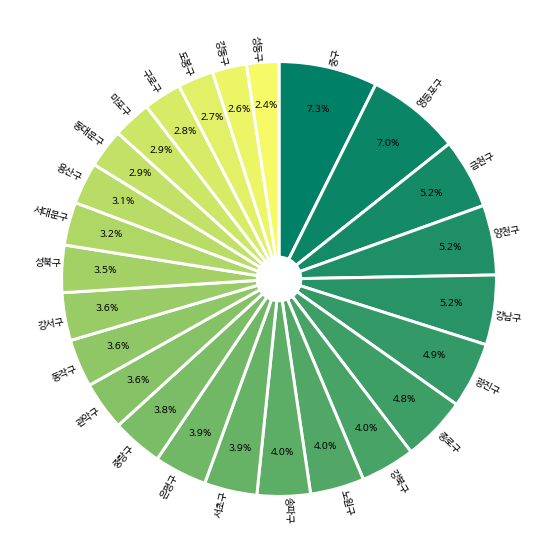

In [ ]:
ratio = sort_ch_acc['ch_acc/child_pop']
labels = sort_ch_acc.index
wedgeprops={'width': 0.9, 'edgecolor': 'w', 'linewidth': 3}
theme = plt.get_cmap('summer')
color = [theme(1. * i / len(sort_ch_acc.index)) for i in range(len(sort_ch_acc.index))]
         
plt.figure(figsize=(10,10))

plt.pie(ratio, labels=labels, autopct='%.1f%%', pctdistance = 0.8, colors = color,
        startangle=90, counterclock=False, labeldistance= 1, rotatelabels=45, 
        wedgeprops=wedgeprops)
plt.show()

# 단속카메라

## 행정구역별 단속카메라 개수

In [ ]:
# 1차 파일 정제
df_cam = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/단속카메라.xlsx',usecols=[1,2,9,10,13])
df_cam = df_cam.query('시도명 == "서울특별시" and 제한속도 != 0').reset_index(drop=True)
df_cam.drop(['시도명','제한속도'], axis=1, inplace=True)

# 단속카메라_위치 저장
df_cam.to_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/단속카메라_위치.csv', index = False)

# 단속카메라 대수
df_cam_cnt = df_cam[['시군구명']]
df_cam_cnt.columns = ['자치구']
df_cam_cnt = df_cam_cnt.groupby('자치구').agg(cam_total = ('자치구', 'count'))
df_cam_cnt.sort_values('cam_total',ascending=False,inplace=True)

In [ ]:
df_cam_cnt

,cam_total
자치구,
은평구,185
종로구,174
서초구,164
송파구,140
영등포구,97
성북구,87
강남구,78
관악구,77
강서구,69


In [ ]:
fig = px.bar(x = df_cam_cnt.index , y = df_cam_cnt['cam_total'])
fig.update_layout(
    title="자치구별 과속카메라대수",
    xaxis_title="자치구",
    yaxis_title="카메라수")

## ** 도로 데이터에 삽입

### 단속카메라 수 / 도로밀도

In [ ]:
# 도로밀도 데이터에 단속카메라 개수 삽입
df_road.insert(2,'cam_total',df_cam_cnt['cam_total'])

# 단속카메라 수 / 도로밀도
df_road['cam/road_km2'] = round((df_road['cam_total'] / df_road['road_km2']),4)

df_road

,road_km2,mean_acc,cam_total,mean_acc/road_km2,ch_acc/child_pop,cam/road_km2
자치구,,,,,,
종로구,0.112923,1028.0,174,9103.5111,0.002302,1540.8667
중구,0.188755,1075.0,43,5695.2128,0.003506,227.8085
용산구,0.144033,1152.0,53,7998.1714,0.001487,367.9714
성동구,0.179122,1097.0,43,6124.3113,0.001144,240.0596
광진구,0.201641,987.0,46,4894.8314,0.002340,228.1279
동대문구,0.221519,1564.0,47,7060.3429,0.001379,212.1714
중랑구,0.158919,1529.0,31,9621.2585,0.001802,195.0680
성북구,0.172091,1411.0,87,8199.1442,0.001675,505.5461
강북구,0.083898,1160.0,29,13826.2626,0.001930,345.6566


## ** 상관계수

In [ ]:
df_road.columns

Index(['road_km2', 'mean_acc', 'cam_total', 'mean_acc/road_km2',
       'ch_acc/child_pop', 'cam/road_km2'],
      dtype='object')

In [ ]:
df_road.iloc[:,[3,5]].corr()

,mean_acc/road_km2,cam/road_km2
mean_acc/road_km2,1.000000,0.398185
cam/road_km2,0.398185,1.000000


<AxesSubplot:xlabel='cam/road_km2', ylabel='mean_acc/road_km2'>

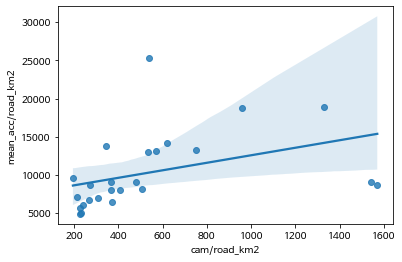

In [ ]:
sns.regplot(x='cam/road_km2',y= 'mean_acc/road_km2', data = df_road)

# 어린이 보호구역

## 행정구역별 어린이 보호구역 수

In [ ]:
# 1차 데이터 정제
df_zone = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/어린이보호구역.xlsx',usecols= [8,9,10], names = ['주소','Longitude','Latitude'])
df_zone['자치구'] = df_zone['주소'].str.split(' ').str[1]

In [ ]:
# 이상치 수정
df_zone['자치구'].value_counts()

강남구       100
노원구       100
양천구        96
성북구        89
송파구        83
강동구        82
광진구        80
은평구        75
강서구        68
관악구        65
영등포구       65
도봉구        63
동대문구       62
구로구        59
서초구        56
동작구        56
마포구        49
금천구        45
성동구        44
중랑구        41
강북구        40
종로구        38
서대문구       35
용산구        33
중구         33
덕릉로62길      1
Name: 자치구, dtype: int64

In [ ]:
df_zone.query('자치구 == "덕릉로62길"')

,주소,Longitude,Latitude,자치구
1458,서울특별시도봉구 덕릉로62길 30,127.041522,37.639953,덕릉로62길


In [ ]:
df_zone['자치구'][1458] = '도봉구'

In [ ]:
# 어린이 보호구역 위치파일 저장
df_zone.to_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/어린이보호구역_위치.csv', index = False)

In [ ]:
# 어린이 보호구역 수
df_zone_cnt = df_zone.iloc[:,[3]]
df_zone_cnt = df_zone_cnt.groupby('자치구').agg(zone_total = ('자치구', 'count'))
df_zone_cnt.sort_values('zone_total',ascending=False, inplace=True)

In [ ]:
fig = px.bar(x = df_zone_cnt.index, y = df_zone_cnt['zone_total'])
fig.update_layout(
    title="자치구별 어린이보호구역",
    xaxis_title="자치구",
    yaxis_title="수")

## ** 도로 데이터에 삽입

### 어린이보호구역 수/도로밀도

In [ ]:
# 삽입
df_road.insert(3,'zone_total',df_zone_cnt['zone_total'])

# 어린이보호구역 수 / 도로밀도
df_road['zone/road_km2'] = df_road['zone_total'] / df_road['road_km2']

df_road

,road_km2,mean_acc,cam_total,zone_total,mean_acc/road_km2,ch_acc/child_pop,cam/road_km2,zone/road_km2
자치구,,,,,,,,
종로구,0.112923,1028.0,174,38,9103.5111,0.002302,1540.8667,336.511111
중구,0.188755,1075.0,43,33,5695.2128,0.003506,227.8085,174.829787
용산구,0.144033,1152.0,53,33,7998.1714,0.001487,367.9714,229.114286
성동구,0.179122,1097.0,43,44,6124.3113,0.001144,240.0596,245.642384
광진구,0.201641,987.0,46,80,4894.8314,0.002340,228.1279,396.744186
동대문구,0.221519,1564.0,47,62,7060.3429,0.001379,212.1714,279.885714
중랑구,0.158919,1529.0,31,41,9621.2585,0.001802,195.0680,257.993197
성북구,0.172091,1411.0,87,89,8199.1442,0.001675,505.5461,517.167849
강북구,0.083898,1160.0,29,40,13826.2626,0.001930,345.6566,476.767677


In [ ]:
# 이상치 제거
df_road_n = df_road.drop(['노원구','강남구'])

## ** 상관계수

In [ ]:
df_road_n.columns

Index(['road_km2', 'mean_acc', 'cam_total', 'zone_total', 'mean_acc/road_km2',
       'ch_acc/child_pop', 'cam/road_km2', 'zone/road_km2'],
      dtype='object')

In [ ]:
df_road_n.iloc[:,[5,7]].corr()

,ch_acc/child_pop,zone/road_km2
ch_acc/child_pop,1.00000,-0.20298
zone/road_km2,-0.20298,1.00000


<AxesSubplot:xlabel='ch_acc/child_pop', ylabel='zone/road_km2'>

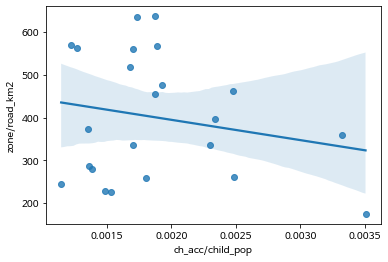

In [ ]:
sns.regplot(x='ch_acc/child_pop',y='zone/road_km2',data=df_road_n)

# 최종결과
- 단속카메라 상관계수: 0.398
- 어린이보호구역 상관계수: -0.203

In [ ]:
df_road.to_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/make_df/df_car_acc.csv',index=False)

In [ ]:
df_car_acc1 = df_road.iloc[:,[4,6]]
df_car_acc2 = df_road_n.iloc[:,[5,7]]

df_car_acc1.corr(), df_car_acc2.corr()

(                   mean_acc/road_km2  cam/road_km2
 mean_acc/road_km2           1.000000      0.398185
 cam/road_km2                0.398185      1.000000,
                   ch_acc/child_pop  zone/road_km2
 ch_acc/child_pop           1.00000       -0.20298
 zone/road_km2             -0.20298        1.00000)